# Full waveform inversion by model extension (FWIME):
# Application to Seiscope's syncline model

---
* Authors: Guillaume Barnier (barnier@gmail.com), Ettore Biondi (ebiondi@caltech.edu), and Stuart Farris (sfarris@sep.stanford.edu)
* Date: 05/12/2022
* Feel free to contact us for any questions or bugs to report

--- 
# About the authors
* [**Guillaume Barnier**](https://www.linkedin.com/in/guillaume-barnier/)
    * Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Research interests: seismic imaging, velocity model building, optimization of large-scale non-convex inverse problems, and machine learning 
    * Guillaume's [personal website](https://gbarnier.github.io)
* [**Ettore Biondi**](https://www.linkedin.com/in/ettore-biondi/)
    * Postdoctoral Researcher at California Institute of Technology in its Seismological Laboratory working within Professor Zhongwen Zhan's research group
    * Former Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Passionate about geophysics, computer science, chemistry, and Earth science
    * Ettore's [personal page](http://www.seismolab.caltech.edu/biondi_e.html)
* [**Stuart Farris**](https://www.linkedin.com/in/stuart-farris/)
    * Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Research interests: Carbon sequestration, machine learning, velocity model building using deep learning, seismic imaging, and inverse problems
    * Currently an AI resident at [X Development](https://x.company)
   
---
# Useful links
* Our YouTube channel ["egoptimization"](https://www.youtube.com/channel/UCjloQO0H6JnddXoB017mcog)
* Stanford Exploration project (SEP) [website](https://sep.sites.stanford.edu) and [YouTube channel](https://www.youtube.com/channel/UCk8h7bfpd-vl_CWCDLHxHzA)
* Ettore's Ph.D. [thesis](http://sepwww.stanford.edu/data/media/public/sep/ettore/pdfs/thesis/thesis_Ettore.pdf) and Ph.D. [defense](https://www.youtube.com/watch?v=cmhhm4HW070&t=2645s) at Stanford University
* Guillaume's Ph.D. [thesis](http://sepwww.stanford.edu/data/media/public/sep/gbarnier/Guillaume_thesis_sep_website.pdf) and Ph.D. [defense](https://www.youtube.com/watch?v=vv9krmVRkMo&t=2309s) at Stanford University

---
# Description
This Jupyter notebook allows you to reproduce the results proposed in Barnier et al. (2022) using the "syncline model" created and shared by the [Seiscope consortium](https://seiscope2.osug.fr). The notebook is organized as follows:
 1. **Setup**:
    * Import libraries
    * Read/load initial/true velocity models (non-reproducible)
    * Read/load the "target" velocity model, which is the FWIME inverted model shown in Barnier et al. (2022) that this notebook will allow you to reproduce
    * Pad velocity models for FD modeling
    * Create mask for gradient
 2. **Conventional data-space mutli-scale FWI**
     * Create wavelet sources and data 
     * Display wavelet time series, wavelet spectrum, and a subset of the dataset
     * Launch inversion on each band
     * Display objective functions and inverted model
 3. **FWIME**
     * For each inversion on a given spline grid: 
         * Map velocity model on current spline grid
         * Create bounds for the mibn/max velocity values on current spline grid
         * Launch inversion on current spline grid
 4. **Results analysis**
      * Display FWIME results (objective functions and inverted velocity models)
 5. **References**

# Summary of main results
* In this notebook, you will be able to reproduce the results from the numerical example proposed in Barnier et al. (2022) on the well-known BP 2004 benchmark model
* In addition to the series of instructions which will allow you to reproduce our resutls, we provide:
    * The initial model, which is very inaccruate
    * The true model 
    * The FWI inverted model shown in Barnier (2022) using unrealistic low-frequency energy. You will reproduce this result in this notebook
    * The FWI inverted model shown in Barnier (2022) using data whose frequency content is restricted to the 3-8 Hz band. You will also reproduce this result to see how poorly conventional FWI performs in this scenario
    * The "target" FWIME model, which is the final FWIME inverted model shown in Barnier et al. (2022). At the end of the notebook, you should be able to recover the exact same model

   

# II. Setup

## Import modules and libraries

env: ACO_GPU_PACK=/opt/acoustic_2d/local/


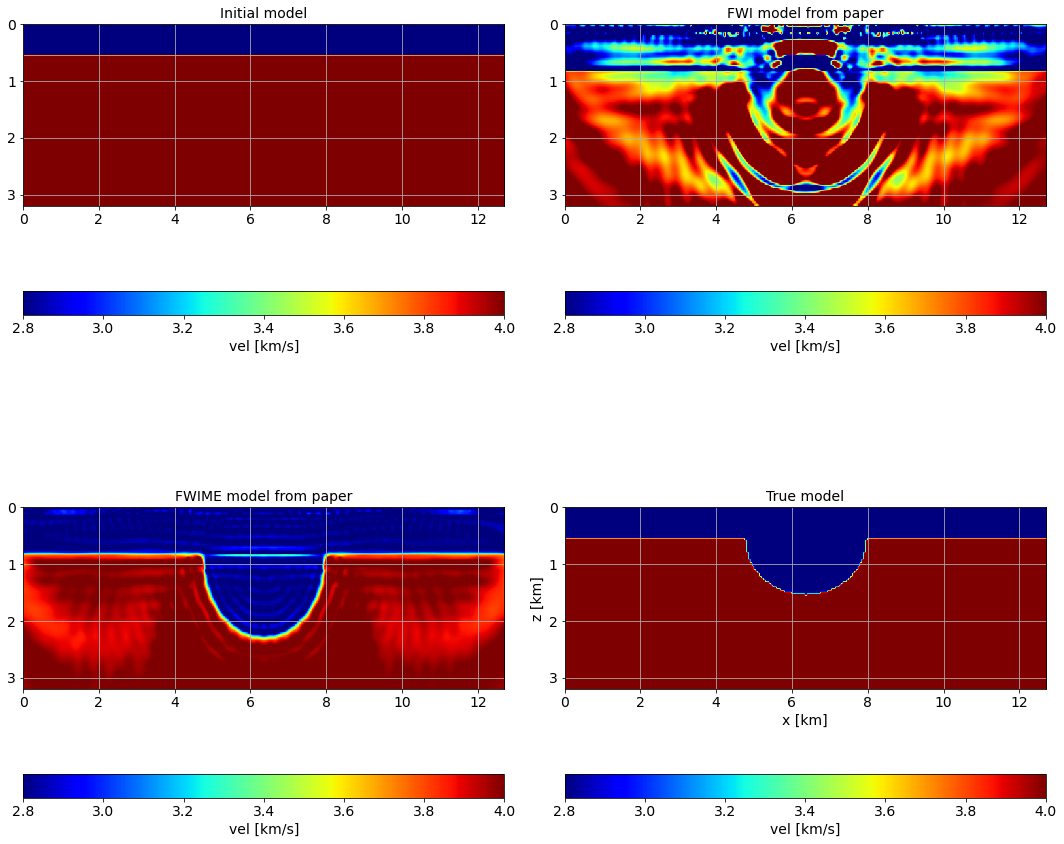

In [19]:
# Import libraries
import genericIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

# Set the path for the executables
%env ACO_GPU_PACK=/opt/acoustic_2d/local/

# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel_non_repro/Syncline-velTrue.H")
vel_init = genericIO.defaultIO.getVector("vel_non_repro/Syncline-velInit.H")
vel_fwime_paper = genericIO.defaultIO.getVector("vel_paper/Syncline_fwime_vel_paper.H")
vel_fwi_paper = genericIO.defaultIO.getVector("vel_paper/Syncline_fwi_vel_paper.H")

# Convert to np arrays
vel_fwime_paper_nd = vel_fwime_paper.getNdArray()
vel_fwi_paper_nd = vel_fwi_paper.getNdArray()
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get model dimensions
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
nz_original = 65
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot initial velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()

# Plot FWI velocity model
img0_1 = axs[0,1].imshow(vel_fwi_paper_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()

# Plot FWIME model
img1_0 = axs[1,0].imshow(vel_fwime_paper_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()

# Plot true model
img1_1 = axs[1,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()

plt.tight_layout()

# Computational time
To give you a sense of the computational time you should expect for the inversions proposed in this notebook, here are some estimations:

1. **Data-space multi-scale FWI**:
    * We use four frequency bands 
    * We conduct 500 L-BFGS iterations per frequency band
    * One L-BFGS iteration of FWI takes approximatelty 12 seconds on 4 x V100 Tesla NVIDIA GPUs
    * The inversion on **one frequency band** takes approximately **1.5 hours**
2. **Model-space multi-scale FWIME**:
    * We use 2 spline grids
    * One L-BFGS iteration of FWIME takes approximatelty 15 min on 4 x V100 Tesla NVIDIA GPUs
    * For instance, the inversion on the first spline requires 30 L-BFGS iterations of FWIME, which corresponds to a compute time of approximately **7.5 hours**
    * **Disclaimer**: The parameter values used in the paper and in this notebook are very conservative. Our goal was to "make it work" before trying to reduce the computational cost, as explained in Barnier et al. (2022)
    * You are welcome to try to play with/adjust the FWIME parameters (in the "par" directory) to reduce the computational cost of FWIME, and observe their effects on the FWIME inverted model
        * Decrease the number of linear iterations for the varaible projection step by setting "nIterLin" to a smaller value
        * Decrease the number of L-BFGS iterations on each spline grid
        * Decrease the extension length "nExt" from 201 to a smaller value
        * Try with a different model extension. In our paper, we use horizontal subsurface offsets but you can try time lags by setting extension=offset 

# 1. Setup

## Velocity models

In [5]:
# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel_non_repro/Syncline-velTrue.H")
vel_init = genericIO.defaultIO.getVector("vel_non_repro/Syncline-velInit.H")

# Get numpy array + hypecube info
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get axes information
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
nz_original = 65
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

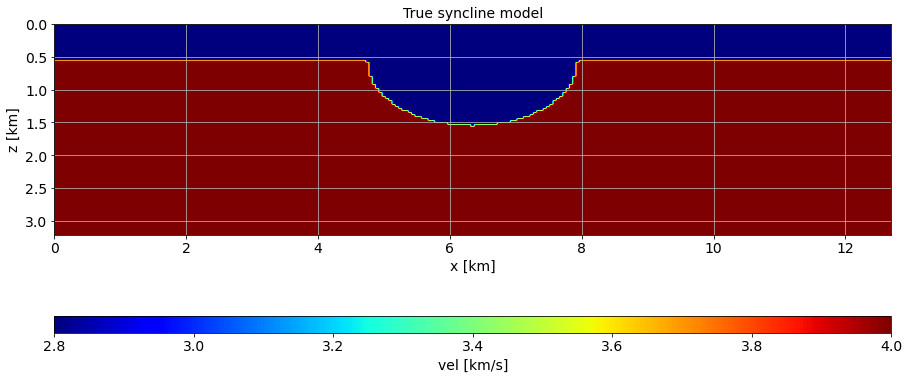

In [6]:
# Plot true velocity model
plt.figure(figsize=(15,10))
plt.imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect="equal")
plt.title("True syncline model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

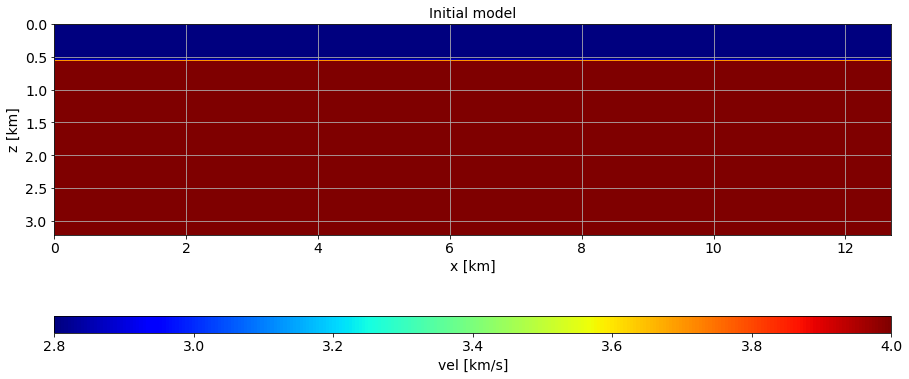

In [7]:
# Plot initial velocity model
plt.figure(figsize=(15,10))
plt.imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## FWIME inverted velocity model from paper ("target" model)
* These is the FWIME inverted velocity model presented in Barnier et al. (2022)
* You should recover this solution after running this Jupyter notebook

In [12]:
# Read FWIME velocity model
vel_target = genericIO.defaultIO.getVector("vel_paper/Syncline_fwime_vel_paper.H")

# Get numpy array + hypercube info
vel_target_nd = vel_target.getNdArray()


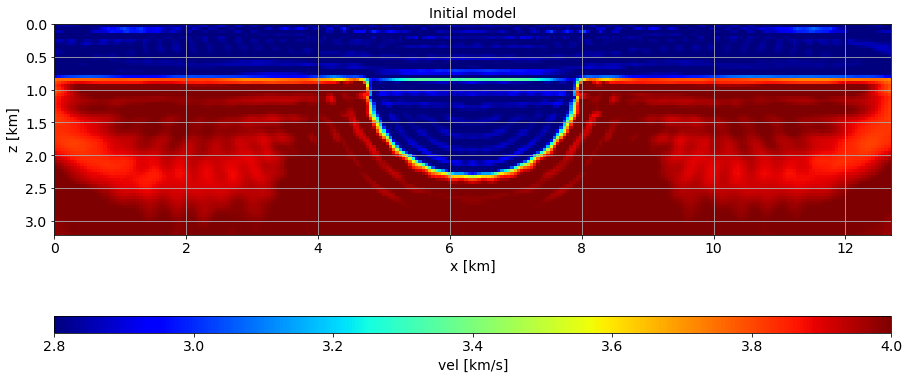

In [13]:
# Plot FWIME velocity model
plt.figure(figsize=(15,10))
plt.imshow(vel_target_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Pad velocity models
In this numerical example, we use absorbing boundaries in all directions

In [ ]:
%%bash

# Pad both initial and true velocity models
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=100 model=vel_non_repro/Syncline-velTrue.H data=vel/Syncline-velTrue.pad.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=100 model=vel_non_repro/Syncline-velInit.H data=vel/Syncline-velInit.pad.H

## Mask for gradient

In [8]:
%%bash

# Create mask for gradient to prevent updates in the water layer
Cp vel/Syncline-velInit.pad.H temp/junk0.H &&\
${ACO_GPU_PACK}/bin/maskGradientMain.py bufferUp=0.4 bufferDown=0.0 wbShift=-0.1 taperExp=2 vel=vel/Syncline-velInit.pad.H model=temp/junk0.H data=temp/junk1.H mask=vel/Syncline-gradientMask.pad.H


--- User has not provided a gradient mask file ---
--- Automatically generating the mask from the provided parameters ---


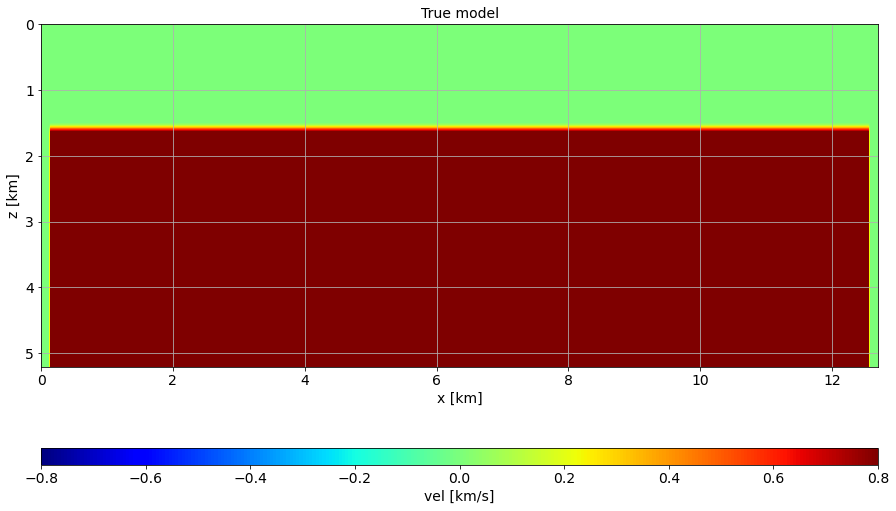

In [9]:
# Display mask
gradient_mask1 = genericIO.defaultIO.getVector("vel/Syncline-gradientMask.pad.H")
gradient_mask1_nd = gradient_mask1.getNdArray()
plt.figure(figsize=(15,10))
plt.imshow(gradient_mask1_nd.T,cmap='jet', vmin=-0.8, vmax=0.8, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Create dummy velocity model 
We create this dummy file to pass the model dimension and hypercube information to the FWIME script and to the spline operator 

In [10]:
%%bash
Cp vel/Syncline-velTrue.pad.H vel/Syncline-velDummy.pad.H

# 2. Conventional data-space multi-scale FWI

## Create wavelet

In [11]:
%%bash

############ Wavelets for conventional FWI ############
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Syncline-1-6.p timeDelay=1.0 fDom=3.0 type=ricker wavelet=temp/junk1.H &&\
Bandpass flo=2 fhi=6 < temp/junk1.H | Bandpass flo=2 fhi=6 | Bandpass flo=2 | fhi=6 Bandpass flo=2 fhi=6 | Bandpass flo=2 fhi=6 | Bandpass flo=2 fhi=6 > wav/Syncline-wav-1-6.H


## Display wavelet

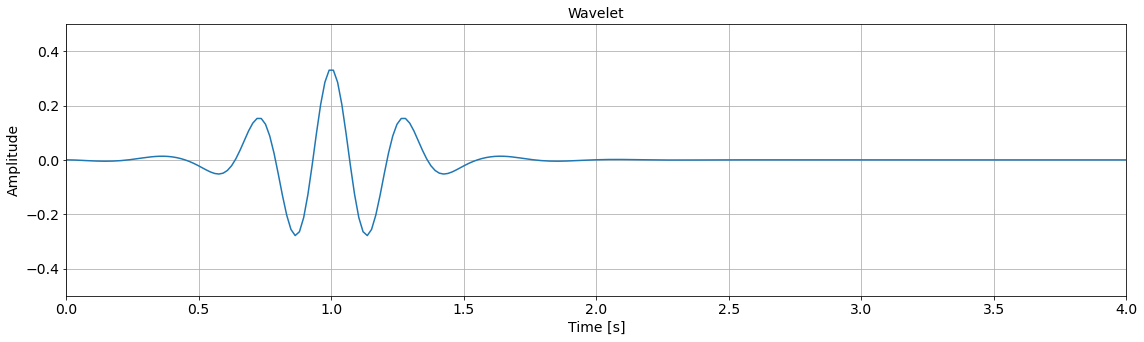

In [12]:
# Read wavelets 
wav_1_6 = genericIO.defaultIO.getVector("wav/Syncline-wav-1-6.H")

# Get numpy arrays
wav_1_6_nd = wav_1_6.getNdArray()

# Get dimensions
wavelet_hyper = wav_1_6.getHyper()
time_axis = wavelet_hyper.getAxis(1)
nt = time_axis.n
ot = time_axis.o
dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(time_range, wav_1_6_nd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-0.5, 0.5])
plt.xlim([0, 4])
plt.grid()
plt.show()



## Plot wavelet spectra

In [13]:
%%bash

############### Create wavelet spectra ###############
Scale < wav/Syncline-wav-1-6.H | Spectra mag=dBnorm > temp/t1.H &&\
Cat axis=2 temp/t1.H > wav/Syncline_temp_spec.H


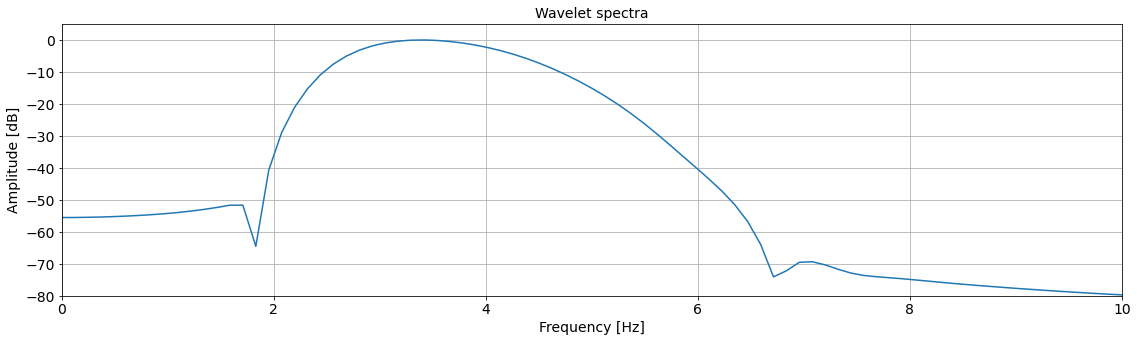

In [14]:
# Read spectra
spectra = genericIO.defaultIO.getVector("wav/Syncline_temp_spec.H")
spectra_Nd = spectra.getNdArray()
spectraHyper = spectra.getHyper()

# Read dimensions
freq_axis = spectraHyper.getAxis(1)
nf = freq_axis.n
of = freq_axis.o
df = freq_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
freq_range = np.linspace(of, of+(nf-1)*df, nf)
plt.plot(freq_range, spectra_Nd.T)
plt.title('Wavelet spectra'), plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude [dB]")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-80, 5])
plt.xlim([0, 10])
plt.grid()
plt.show()


## Generate data

In [ ]:
%%bash

# 1-6 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Syncline-1-6.p vel=vel/Syncline-velTrue.pad.H model=wav/Syncline-wav-1-6.H data=dat/Syncline-dataTrue-1-6.H info=0 


## Read and display data

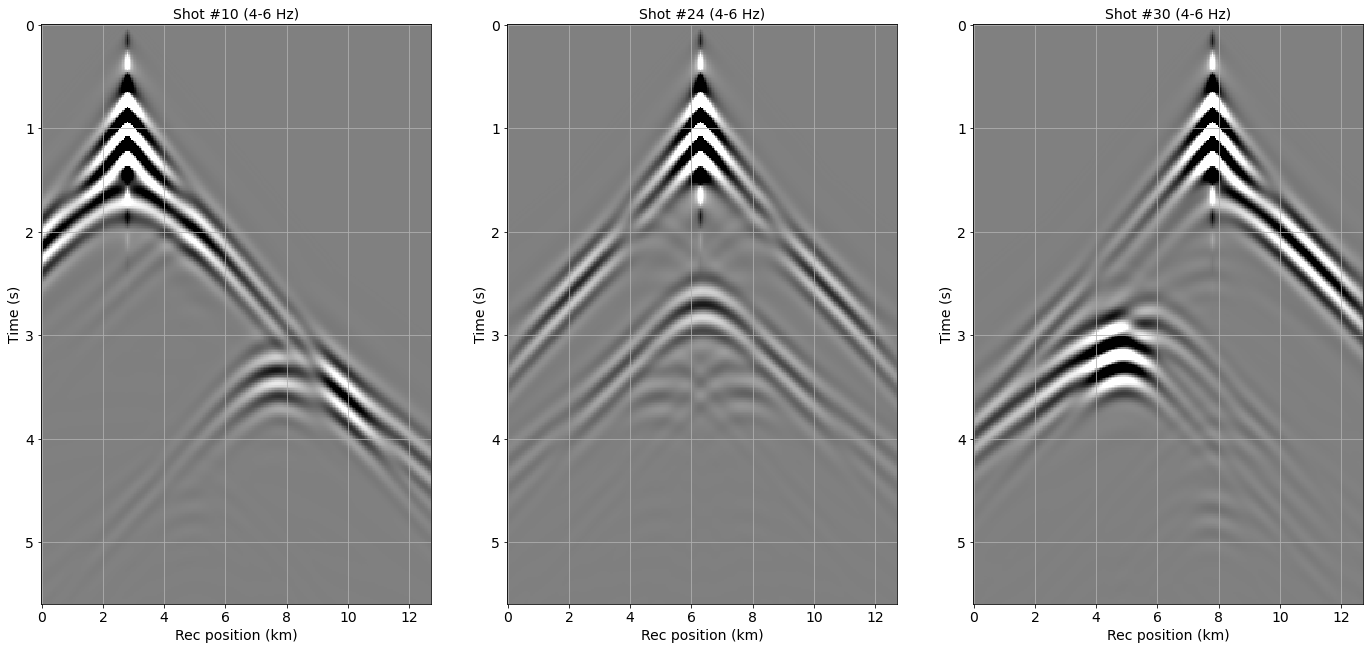

In [16]:
# Read data
data_1_6 = genericIO.defaultIO.getVector("dat/Syncline-dataTrue-1-6.H")

# Display data
data_1_6_nd = data_1_6.getNdArray()

# Clipping
pclip=98
clip = np.percentile(np.abs(data_1_6_nd), pclip)

# Dimensions
o_rec = data_1_6.getHyper().getAxis(2).o
d_rec = data_1_6.getHyper().getAxis(2).d
n_rec = data_1_6.getHyper().getAxis(2).n
rec_range = np.linspace(o_rec, o_rec+(n_rec-1)*d_rec, n_rec)

# Display shot gathers
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# First frequency band: 4-6 Hz
shot1 = 10
axs[0].pcolormesh(rec_range, time_range, data_1_6_nd[shot1].T,vmin=-clip,vmax=clip)
axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_ylabel('Time (s)')
axs[0].set_xlabel('Rec position (km)')
axs[0].set_title('Shot #' + str(shot1) + " (4-6 Hz)")

shot2 = 24
axs[1].pcolormesh(rec_range, time_range, data_1_6_nd[shot2].T,vmin=-clip,vmax=clip)
axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_ylabel('Time (s)')
axs[1].set_xlabel('Rec position (km)')
axs[1].set_title('Shot #' + str(shot2) + " (4-6 Hz)")

shot3 = 30
axs[2].pcolormesh(rec_range, time_range, data_1_6_nd[shot3].T,vmin=-clip,vmax=clip)
axs[2].invert_yaxis()
axs[2].grid()
axs[2].set_ylabel('Time (s)')
axs[2].set_xlabel('Rec position (km)')
axs[2].set_title('Shot #' + str(shot3) + " (4-6 Hz)")

plt.tight_layout(pad=3.0)
plt.show()

## Conventional FWI

In [ ]:
%%bash

# 4-6 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Syncline-1-6.p sources=wav/Syncline-wav-1-6.H vel=vel/Syncline-velInit.pad.H data=dat/Syncline-dataTrue-1-6.H nIter=500 folder=inv/Syncline-fwi-1-6 minBound=2.3 maxBound=4.3 solver=lbfgs gradientMask=1 gradientMaskFile=vel/Syncline-gradientMask.pad.H

## Display FWI results

### Objective functions

In [ ]:
############# Objective functions #############
# Read file 
obj_fwi_1_6 = genericIO.defaultIO.getVector("inv/Syncline-fwi-1-6/Syncline-fwi-1-6_obj.H")


# Convert to numpy array
obj_fwi_1_6_nd = obj_fwi_1_6.getNdArray()

# Plot 
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(obj_fwi_1_6_nd/obj_fwi_1_6_nd[0])
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.subplot(122)
plt.plot(np.log10(obj_fwi_1_6_nd/obj_fwi_1_6_nd[0]))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()



### FWI inverted models

In [51]:
%%bash

# Remove padding from inverted models
Window3d n1=105 f1=55 n2=255 f2=105 < inv/Syncline-fwi-1-6/Syncline-fwi-1-6_inv_mod.H > inv/Syncline_inv_mod_1_6.H 


(3,)


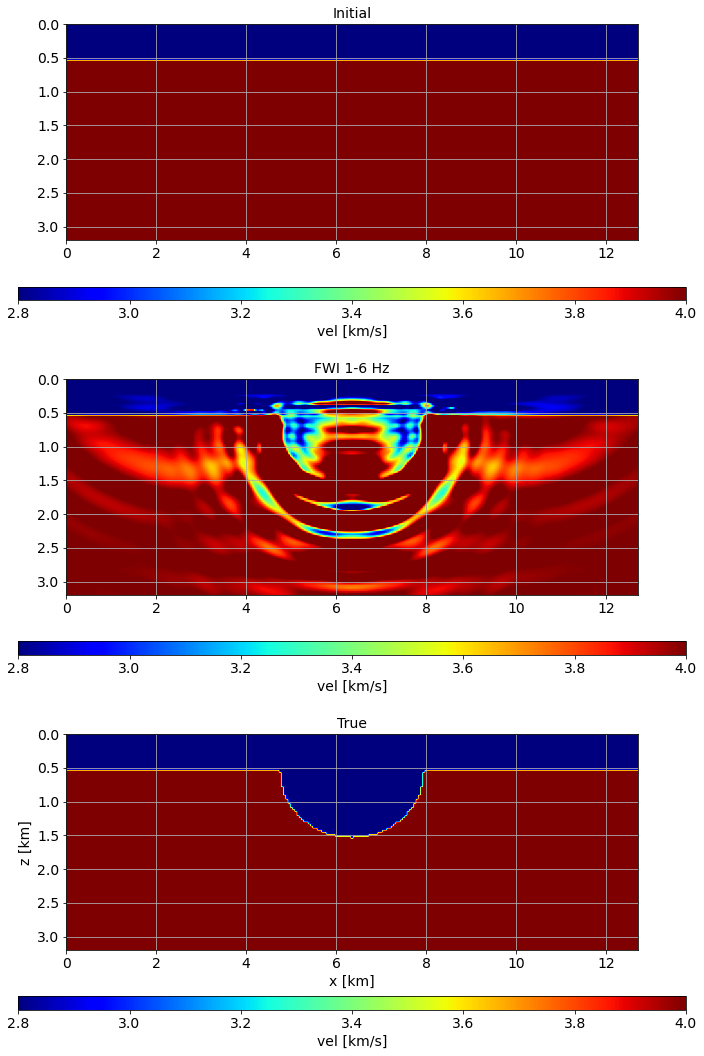

In [70]:
# Read inverted models
model_1_6 = genericIO.defaultIO.getVector("inv/Syncline_inv_mod_1_6.H")

# Convert to numpy arrays
model_1_6_nd = model_1_6.getNdArray()

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Initial velocity model
img0_0 = axs[0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[0].set_title("Initial"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0], orientation="horizontal", label="vel [km/s]", aspect=50)
axs[0].grid()

# Plot 1-6 Hz velocity model
img1_0 = axs[1].imshow(model_1_6_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[1].set_title("FWI 1-6 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1], orientation="horizontal", label="vel [km/s]", aspect=50)
axs[1].grid()

# Plot 4-13 Hz velocity model
img2_0 = axs[2].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[2].set_title("True"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2], orientation="horizontal", label="vel [km/s]", aspect=50)
axs[2].grid()

plt.tight_layout()
    

# 3. FWIME
* We conduct a model-space multi-scale FWIME on 2 spline grids
* One L-BFGS iteration of FWIME take approximately 15 minutes on 4 x V100 Tesla NVIDIA GPUs

## Upper and lower velocity bounds computation
* We choose lower/upper velocity values $v_{min}$ and $v_{max}$ to prevent the velocity model from taking values that would create FD instability or dispersion
* However, the step length calculation and the model updates are conducted on the spline grid (see Barnier et. al, 2022), so we need to express these bounds on the spline grid
* For each spline grid, we create two constant velocity models on the FD grid whose values are set to $v_{min}$ and $v_{max}$, respectively
* We map these constant velocity models onto the spline grid by applying the adjoint of the spline mapping operator
* We use the output of this adjoint mapping as lower/upper bounds on the spline grid (which is where our unknown model is parametrized)

In [ ]:
%%bash

################### Bounds for spline grid 1 ###################
# Max bounds
Vel n1=105 n2=255 n3=1 d1=0.05 d2=0.05 d3=0.05 vc=4.6 > temp/junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=100 model=temp/junkMax.H data=temp/junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMax.pad.H model=vel/Syncline-fwime-1-6-spline1-maxBound.H adj=1 par=par/Syncline-fwime-1-6-spline1.p vel=vel/Syncline-velDummy.pad.H &&\

# Min bounds on spline 1
Vel n1=105 n2=255 n3=1 d1=0.05 d2=0.05 d3=0.05 vc=4.6 > temp/junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=100 model=temp/junkMin.H data=temp/junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMin.pad.H model=vel/Syncline-fwime-1-6-spline1-minBound.H adj=1 par=par/Syncline-fwime-1-6-spline1.p vel=vel/Syncline-velDummy.pad.H

## FWIME on spline grid 1

### Generate initial model onto first spline grid
* In step II of this notebook, we created/read the initial velocity model $\mathbf{m}^f_{init}$ defined on the (fine) FD grid 
* We now need to convert it (or map it) onto the first coarse spline grid $c_1$ in order to obtain the initial model for the FWIME inversion, $\mathbf{m}^{c_1}_{init}$
* The mapping is done by finding the unique minimizer of the following loss function:

$\mathbf{m}^{c_1}_{init} = \underset{\mathbf{m}^{c_1}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_1 \mathbf{m}^{c_1} - \mathbf{m}^f_{init} \right \|_2^2$
* $\mathbf{S}_1$ is the spline mapping operator (from the first coarse spline grid -> fine grid)
* $\mathbf{m}^{c_1}$ corresponds to any model defined on the first spline grid



In [ ]:
%%bash

# Create directory spline2dJunk (you might have to create it manually by typing "mkdir spline2dJunk")
# Map initial model onto the first spline grid
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/Syncline-velDummy.pad.H data=vel/Syncline-velInit.pad.H par=par/Syncline-fwime-1-6-spline1.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/Syncline-coarseInit-fwime-1-6-spline1.H


### Launch inversion on spline grid 1
* Conduct 30 L-BFGS iterations on spline grid 1
* One L-BFGS iteration of FWIME takes approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs, so **7.5 hours** for 30 iterations

In [44]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Syncline-fwime-1-6-spline1.p vel=vel/Syncline-velDummy.pad.H sources=wav/Syncline-wav-1-6.H data=dat/Syncline-dataTrue-1-6.H folderNl=inv/Syncline-fwime-1-6-spline1 modelCoarseInit=vel/Syncline-coarseInit-fwime-1-6-spline1.H minBoundVector=vel/Syncline-fwime-1-6-spline1-minBound.H maxBoundVector=vel/Syncline-fwime-1-6-spline1-maxBound.H epsilon=1e-5 gradientMask=1 gradientMaskFile=vel/Syncline-gradientMask.pad.H sloth=0

Process is terminated.


## FWIME on spline grid 2 (FD grid)

### Map inverted model on spline 1 into spline 2 (FD grid)

In [ ]:
%%bash

Window3d n3=1 f3=0 < inv/Syncline-fwime-1-6-spline1/Syncline-fwime-1-6-spline1_inv_mod.H > vel/Syncline-fwime-inv-mod-spline1.pad.H &&\
# Map inverted model from spline 1 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=vel/Syncline-coarseInit-fwime-1-6-noSpline.H model=vel/Syncline-fwime-inv-mod-spline1.pad.H adj=0 par=par/Syncline-fwime-1-6-spline1.p vel=vel/Syncline-velDummy.pad.H

### Launch inversion on spline grid 2 (FD grid)
* Conduct 30 L-BFGS iterations on spline grid 2
* One L-BFGS iteration of FWIME takes approximately 15 minutes on 4 x V100 Tesla NVIDIA GPUs, so **7.5 hours** for 30 iterations

In [ ]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Syncline-fwime-1-6-noSpline.p vel=vel/Syncline-coarseInit-fwime-1-6-noSpline.H sources=wav/Syncline-wav-1-6.H data=dat/Syncline-dataTrue-1-6.H folderNl=inv/Syncline-fwime-1-6-noSpline epsilon=1e-4 minBound=2.3 maxBound=4.3 gradientMask=1 gradientMaskFile=vel/Syncline-gradientMask.pad.H sloth=0

## FWIME -> FWI
To speed-up the inversion, we finish FWIME with FWI. We use the FWIME inverted model on spline 2 as an input for FWI

In [74]:
%%bash

# Extract last inverted model from spline 2
Window3d n3=1 f3=0 < inv/Syncline-fwime-1-6-noSpline/Syncline-fwime-1-6-noSpline_inv_mod.H > vel/Syncline-fwime-inv-mod-spline2.pad.H &&\
# Launch FWI
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Syncline-fwime-1-6-noSpline.p sources=wav/Syncline-wav-1-6.H vel=vel/Syncline-fwime-inv-mod-spline2.pad.H data=dat/Syncline-dataTrue-1-6.H nIter=500 folder=Syncline-fwime-1-6-noSpline-fwi minBound=2.3 maxBound=4.3 solver=lbfgs

# V. FWIME results analysis

In [ ]:
%%bash

# Extract and crop inverted models on each spline grids
Window3d n1=65 f1=55 n2=255 f2=105 < vel_non_repro/Syncline-velTrue.pad.H > vel/Syncline-velTrue-shallow.H &&\ 
Window3d n1=65 f1=55 n2=255 f2=105 < vel_non_repro/Syncline-velInit.pad.H > vel/Syncline-velInit-shallow.H &&\ 
Window3d n1=65 f1=55 n2=255 f2=105 < vel/Syncline-fwime-inv-mod-spline1.pad.H > vel/Syncline-fwime-inv-mod-spline1.H &&\ 
Window3d n1=65 f1=55 n2=255 f2=105 < vel/Syncline-fwime-inv-mod-spline2.pad.H > vel/Syncline-fwime-inv-mod-spline2.H &&\
Window3d n1=65 f1=55 n2=255 f2=105 < inv/Syncline-fwime-1-6-noSpline-fwi/Syncline-fwime-1-6-noSpline-fwi_inv_mod.H > vel/Syncline-fwime-fwi-inv-mod.H &&\
Window3d n1=65 f1=55 n2=255 f2=105 < inv/Syncline-fwi-1-6/Syncline-fwi-1-6_inv_mod.H > vel/Syncline_fwi_inv_mod_1_6_shallow.H 


In [ ]:
# Read inverted models

vel_true = genericIO.defaultIO.getVector("vel/Syncline-velTrue-shallow.H")
vel_init = genericIO.defaultIO.getVector("vel/Syncline-velInit-shallow.H")
model_fwi = genericIO.defaultIO.getVector("vel/Syncline_fwi_inv_mod_1_6_shallow.H ")
model_fwime_s1 = genericIO.defaultIO.getVector("vel/Syncline-fwime-inv-mod-spline1.H")
model_fwime_s2 = genericIO.defaultIO.getVector("vel/Syncline-fwime-inv-mod-spline2.H")
model_fwime_fwi = genericIO.defaultIO.getVector("vel/Syncline-fwime-fwi-inv-mod.H ")

# # Convert to numpy arrays
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
model_fwi_nd = model_fwi.getNdArray()
model_fwime_s1_nd = model_fwime_s1.getNdArray()
model_fwime_s2_nd = model_fwime_s2.getNdArray()
model_fwime_fwi_nd = model_fwime_fwi.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot true velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()
# plt.show()

# Plot initial velocity model
img0_1 = axs[0,1].imshow(model_fwi_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 4-13 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()
# plt.show()

# Plot true velocity model
img1_0 = axs[1,0].imshow(model_fwime_s1_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME spline 1"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot initial velocity model
img1_1 = axs[1,1].imshow(model_fwime_s2_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWIME spline 2"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()
# plt.show()

# Plot true velocity model
img2_0 = axs[2,0].imshow(model_fwime_fwi_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWIME FD grid"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()
# plt.show()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz_original-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True velocity"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()
# plt.show()

plt.tight_layout()


## VI. References

* Barnier, G., E. Biondi, R. G. Clapp, and B. Biondi, 2022, Full waveform inversion by model extension: practical applications (manuscript submitted to Geophysics)